# CNN 
* Pre trained using weights of 'best' model: densenet121_NotNorm.pth
* ?Use saliency maps for generation of bounding boxes
* Idea (13/09): first plot three xai maps (eg: shap, gradcam, lime) next to eachother to see and compare
* * use small test set of 'obvious' samples (5/5) to inspect accuracy

## Load Pre-trained model

In [9]:
import os
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torch import nn, optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time
import collections
from collections import Counter


In [10]:
# get data
class DRData(Dataset):
    def __init__(self, root_dir, subset='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        subdir = f'{subset}/subset_ND'
        dir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'):
                self.image_paths.append(os.path.join(dir_path, filename))
                label = 1 if filename.split('_')[1].startswith('D') else 0 # so 1 for DR, 0 for NO DR
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # of naar 128 ?
    transforms.ToTensor()
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # also try when skipping normalize 
])
from sklearn.model_selection import train_test_split

# Load Datasets
train_dataset = DRData(root_dir='Data', subset='train', transform=data_transforms)


# Split Train into Train/Validation
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check the distribution again
def check_data_distribution(labels, dataset_name='Dataset'):
    class_counts = Counter(labels)
    print(f"Data Distribution for {dataset_name}:")
    for label, count in class_counts.items():
        print(f"Class {label}: {count} samples")

check_data_distribution(train_labels, 'Training Dataset (Stratified)')
check_data_distribution(val_labels, 'Validation Dataset (Stratified)')


Data Distribution for Training Dataset (Stratified):
Class 0: 127 samples
Class 1: 128 samples
Data Distribution for Validation Dataset (Stratified):
Class 1: 22 samples
Class 0: 23 samples


In [11]:
# evaluation of model on test set 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # plt.figure(figsize=(6, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()

    return accuracy, precision, recall, f1

# Load the model if weights are saved already 
def load_model(saved_weights):
    model = models.densenet121(pretrained=True) # denseNet pre trained
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load(saved_weights))
    model = model.to(device)
    return model


# Path to the saved model weights
saved_weights = 'CNNModelWeights/densenet121_NotNorm.pth'

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(saved_weights)

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

# 1 = DR
# 0 = No DR

#true
# 0
# 1
#   0 1  predicted

/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[35 15]
 [ 0 50]]
Accuracy: 0.8500
Precision: 0.7692
Recall: 1.0000
F1 Score: 0.8696


## Get bb from saliency maps

Maybe best to use grad-CAM:

"Gradient-based techniques (Chaddad et al., 2023; Ennab & Mcheick, 2022), such as Grad-CAM, use gradients to create heatmaps, providing real-time visual explanations, while perturbation-based methods, like LIME, alter input data to observe changes in predictions, offering robust, model-agnostic explanations though often at higher computational cost."

### try2

In [65]:
# GradCAM explanations 

"""
Extracting intermediate feature maps:
compute gradients of the target class wrt conv layer 
"""
class FeatureExtractor:
    """ Class for extracting (intermediate?) activations and registering gradients from target intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []
        self.activations = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        for name, module in self.model.features._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                self.activations.append(x)
        return self.activations, x

"""
Generate grad-CAM heatmap for sinle image
>> feature extraction, prediction, backward pass for grad computation, generation of heatmap (class activation map (CAM)
"""
def generate_heatmap(model, image, target_layer):
    extractor = FeatureExtractor(model, target_layer)
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Forward pass to get predictions and target feature maps
    target_activations, output = extractor(image)
    output = F.relu(output, inplace=True)
    output = F.adaptive_avg_pool2d(output, (1, 1)).view(output.size(0), -1)
    output = model.classifier(output)
    pred_class = torch.sigmoid(output).round().item()

    # Backward pass to get gradients wrt the predicted class
    model.zero_grad()
    class_loss = output[0]  # For binary classification
    class_loss.backward(retain_graph=True)

    #  gradients and target layer output
    gradients = extractor.gradients[0].cpu().data.numpy()
    target = target_activations[0].cpu().data.numpy()

    #  heatmap
    weights = np.mean(gradients, axis=(2, 3))[0, :]
    cam = np.zeros(target.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * target[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    #print(cam, pred_class)
    return cam, pred_class

# Visualize 
def visualize_heatmap(original_image, heatmap, image_name):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Since normalization is skipped, directly convert the tensor to a numpy array
    original_image = original_image.cpu().permute(1, 2, 0).numpy()
    original_image = np.clip(original_image, 0, 1)
    
    superimposed_img = heatmap + np.float32(original_image)
    superimposed_img = superimposed_img / np.max(superimposed_img)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image 
    ax[0].imshow(original_image)
    ax[0].set_title(image_name)
    ax[0].axis('off')
    
    # Grad-CAM heatmap
    ax[1].imshow(superimposed_img)
    ax[1].set_title('Grad-CAM Heatmap')
    ax[1].axis('off')
    
    plt.show()

"""
Evaluate + Grad-CAM heatmaps
But only for images where the true label is 1 (only BB for DR images)
"""
def evaluate_and_visualize_gradcam(model, test_loader, device, target_layer, num_images):
    count = 0
    for images, labels in test_loader:
        if count >= num_images:
            break
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).round().detach().cpu().numpy()  # Detach and convert to numpy

        label = labels.cpu().numpy()[0]
        prediction = preds[0][0]

        # Only show when DR is present eg  1
        if label == 1:  
            image_name = f"Actual: 1, Predicted: {prediction}"

            # Grad-CAM heatmap
            heatmap, pred_class = generate_heatmap(model, images[0], target_layer)

            # Visualize heatmap with the image label/name as title
            visualize_heatmap(images[0], heatmap, image_name)
        
        count += 1


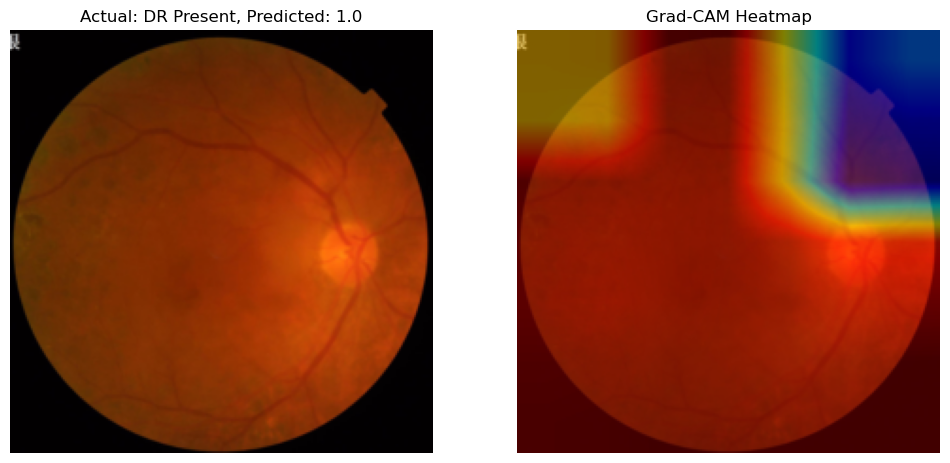

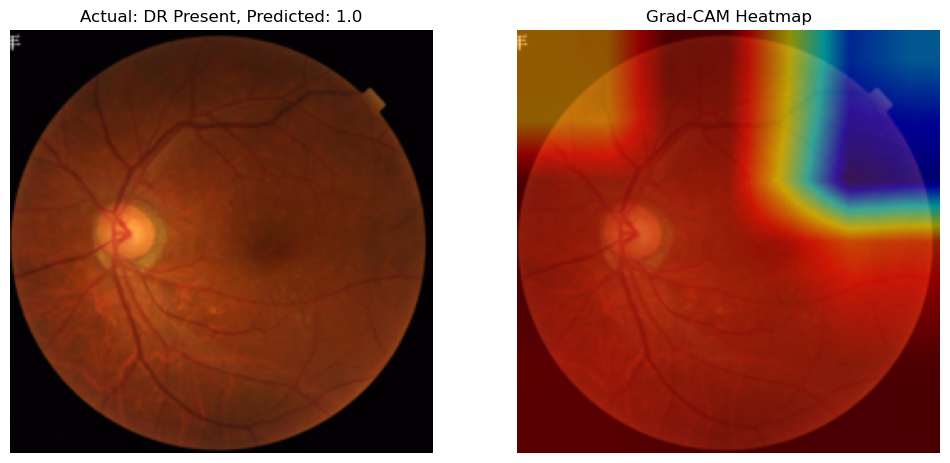

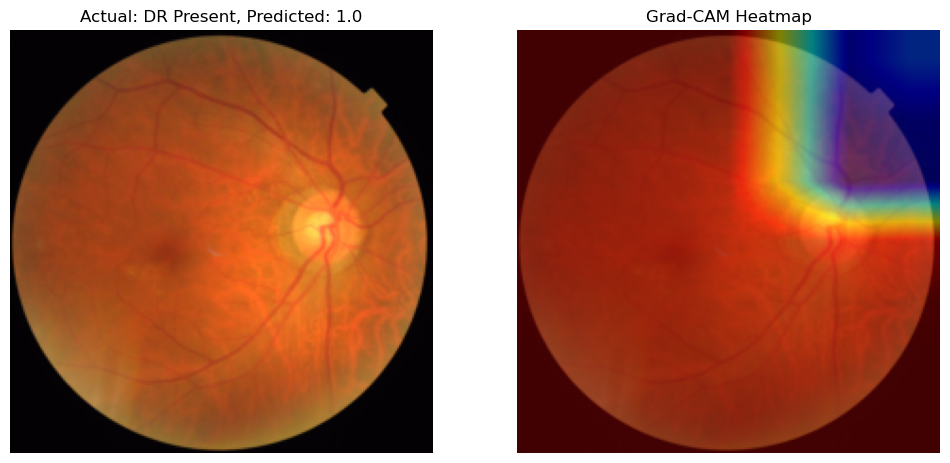

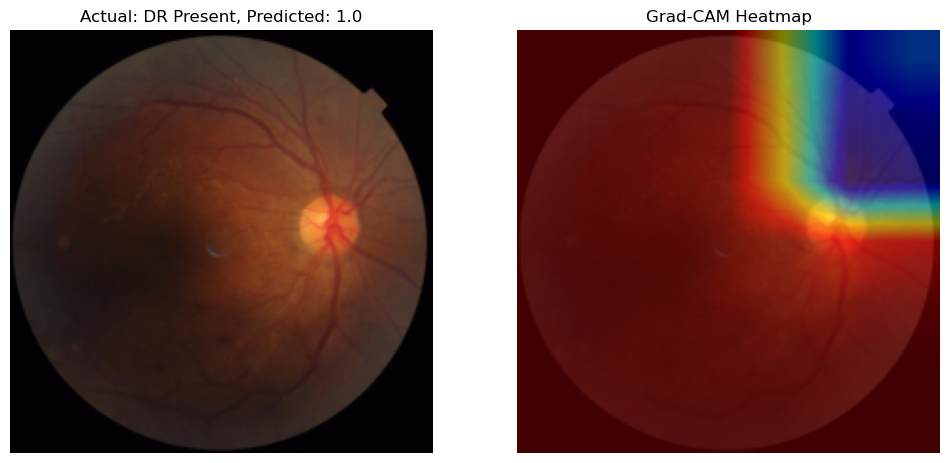

In [63]:
# tr
evaluate_and_visualize_gradcam(model, test_loader, device, target_layer=['denseblock4'], num_images=4)

### try3 - wip

GradCam - hierbven 

Saliency Map

In [56]:
def saliency_map(model, image, target_class):
    image.requires_grad_()
    
    # Forward pass
    model.eval()
    output = model(image)
    
    # Get score for the target class
    score = output[:, target_class].sum()

    # Backprop to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the gradient of the input image
    saliency = image.grad.data.abs().squeeze().cpu().numpy()

    # Normalize the saliency map
    saliency = np.max(saliency, axis=0)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    return saliency

def visualize_saliency_map(model, image, target_class):
    saliency_map = saliency_map(model, image, target_class)
    
    # Plot the saliency map
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.show()


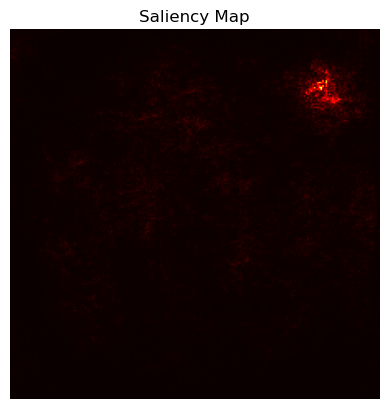

In [58]:
# For a specific image:
image, label = next(iter(test_loader))  # Get a batch from the test loader
image = image[0].unsqueeze(0).to(device)  # Take the first image from the batch

# Saliency map for the predicted class
pred_class = 0  # You can modify this based on your output
visualize_saliency_map(model, image, pred_class)


Integrated Gradients

In [46]:
!pip install captum

  Obtaining dependency information for captum from https://files.pythonhosted.org/packages/e1/76/b21bfd2c35cab2e9a4b68b1977f7488c246c8cffa31e3361ee7610e8b5af/captum-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:0000:0100:01


In [47]:
from captum.attr import IntegratedGradients

def generate_integrated_gradients(model, image, target_class, baseline=None):
    # Use Captum to generate integrated gradients
    integrated_gradients = IntegratedGradients(model)
    
    if baseline is None:
        baseline = torch.zeros_like(image).to(device)  # A black image as baseline

    attributions = integrated_gradients.attribute(image, baseline, target=target_class)
    
    return attributions.squeeze().cpu().detach().numpy()

def visualize_integrated_gradients(attributions):
    # Normalize and visualize
    attribution_image = np.mean(attributions, axis=0)  # Take the mean over channels
    attribution_image = np.maximum(attribution_image, 0)  # ReLU
    attribution_image = (attribution_image - attribution_image.min()) / (attribution_image.max() - attribution_image.min())

    plt.imshow(attribution_image, cmap='hot')
    plt.axis('off')
    plt.title('Integrated Gradients')
    plt.show()


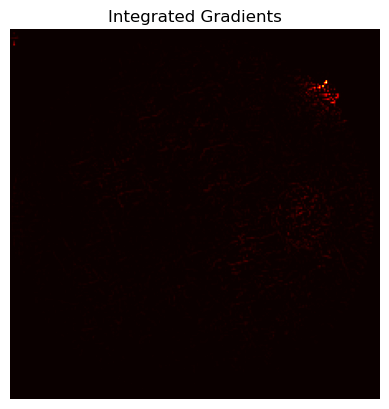

In [61]:

# Integrated gradients for the predicted class
attributions = generate_integrated_gradients(model, image, pred_class)
visualize_integrated_gradients(attributions)
